# Notebook 25 - Optimisation des Poids de l'IMD

**Résumé** : Ce notebook explore si les poids normatifs de l'IMD
($w_S=0.30$, $w_E=0.25$, $w_D=0.20$, $w_P=0.15$, $w_M=0.10$)
peuvent être améliorés algorithmiquement. Trois méthodes sont comparées :

1. **CRITIC** (non-supervisé) : pondération par contenu informationnel
2. **Optimisation supervisée** : maximisation de la corrélation de Spearman
   avec le baromètre FUB 2023 et la part modale vélo EMP 2019
3. **Monte Carlo** : analyse de sensibilité - stabilité du classement top-10
   sous 10 000 tirages de poids aléatoires

**Objectif** : évaluer si les poids normatifs sont robustes, ou s'il existe
des jeux de poids alternatifs qui alignent mieux l'IMD sur des mesures
indépendantes de l'usage vélo.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats import spearmanr, pearsonr
from scipy.optimize import differential_evolution, LinearConstraint
from scipy.stats import dirichlet
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)
print("Libraries loaded ✓")


Libraries loaded ✓


In [2]:
import os
OUTPUT_DIR  = "../../output/25_Optimisation_Poids_IMD"
FIGURES_DIR = f"{OUTPUT_DIR}/figures"
TABLES_DIR  = f"{OUTPUT_DIR}/tables_csv"
os.makedirs(FIGURES_DIR, exist_ok=True)
os.makedirs(TABLES_DIR,  exist_ok=True)

COMPS      = ['C1_S', 'C2_E', 'C3_D', 'C4_P', 'C5_M']
COMP_NAMES = ['S - Couverture', 'E - Équité', 'D - Densité',
              'P - Offre/hab.', 'M - Multimodalité']
W_NORM = np.array([0.30, 0.25, 0.20, 0.15, 0.10])   # poids normatifs

W_MIN  = 0.05   # borne inférieure de chaque poids
N_MC   = 10_000 # itérations Monte Carlo

COLORS = {
    'norm':     '#2c3e50',
    'fub':      '#e74c3c',
    'emp':      '#3498db',
    'combined': '#27ae60',
    'critic':   '#9b59b6',
}
print("Config ready ✓")


Config ready ✓


In [3]:
# IMD components
df_imd = pd.read_csv(
    "../../output/21_Classement_Villes_Mobilite_Douce/tables_csv/imd_classement.csv"
)

# External references
df_fub = pd.read_csv("../../data/external/mobility_sources/fub_barometre_2023_city_scores.csv")
df_emp = pd.read_csv("../../data/external/mobility_sources/emp_2019_city_modal_share.csv")

# Merge on city
df = (df_imd[['rang','city','IMD'] + COMPS]
      .merge(df_fub[['city','fub_score_2023']], on='city', how='left')
      .merge(df_emp[['city','emp_part_velo_2019']], on='city', how='left'))

# Drop rows with NaN in any component (3 cities without population)
df_full = df.dropna(subset=COMPS).copy()
X_all   = df_full[COMPS].values    # (n, 5)
IMD_norm = df_full['IMD'].values

print(f"Total villes         : {len(df_imd)}")
print(f"Villes avec C1..C5   : {len(df_full)}  (sans NaN composantes)")
print(f"Avec score FUB       : {df_full['fub_score_2023'].notna().sum()}")
print(f"Avec part EMP        : {df_full['emp_part_velo_2019'].notna().sum()}")
print()
# Sub-datasets for optimization
mask_fub  = df_full['fub_score_2023'].notna()
mask_emp  = df_full['emp_part_velo_2019'].notna()
mask_both = mask_fub & mask_emp

X_fub  = X_all[mask_fub];  y_fub  = df_full.loc[mask_fub,  'fub_score_2023'].values
X_emp  = X_all[mask_emp];  y_emp  = df_full.loc[mask_emp,  'emp_part_velo_2019'].values
X_both = X_all[mask_both]; y_fub2 = df_full.loc[mask_both, 'fub_score_2023'].values
y_emp2 = df_full.loc[mask_both, 'emp_part_velo_2019'].values

print(f"Jeu FUB  : n={mask_fub.sum()}, {mask_emp.sum()} EMP, {mask_both.sum()} les deux")

# Verify normative IMD = X_all @ W_NORM (up to rounding for cities without C4_P)
imd_check = X_all @ W_NORM
corr_check = spearmanr(imd_check, IMD_norm).statistic
print(f"Vérif. w_norm : ρ(IMD_recalc, IMD_officiel) = {corr_check:.4f}")


Total villes         : 62
Villes avec C1..C5   : 59  (sans NaN composantes)
Avec score FUB       : 34
Avec part EMP        : 46

Jeu FUB  : n=34, 46 EMP, 34 les deux
Vérif. w_norm : ρ(IMD_recalc, IMD_officiel) = 1.0000


In [4]:
print("=== Corrélations de BASE (poids normatifs) ===")
imd_w_norm = X_all @ W_NORM

r_fub_norm = spearmanr(imd_w_norm[mask_fub], y_fub).statistic
r_emp_norm = spearmanr(imd_w_norm[mask_emp], y_emp).statistic

print(f"  ρ(IMD_norm, FUB)  = {r_fub_norm:+.4f}  (n={mask_fub.sum()})")
print(f"  ρ(IMD_norm, EMP)  = {r_emp_norm:+.4f}  (n={mask_emp.sum()})")
print()
# Also: individual component correlations with references
print("Corrélations par composante vs FUB/EMP :")
print(f"{'Comp':5s}  {'vs FUB':>8s}  {'vs EMP':>8s}")
for c, name in zip(COMPS, COMP_NAMES):
    vals = X_all[:, COMPS.index(c)]
    r_f  = spearmanr(vals[mask_fub], y_fub).statistic
    r_e  = spearmanr(vals[mask_emp], y_emp).statistic
    print(f"{c:5s}  {r_f:+8.3f}  {r_e:+8.3f}  ← {name}")


=== Corrélations de BASE (poids normatifs) ===
  ρ(IMD_norm, FUB)  = +0.1622  (n=34)
  ρ(IMD_norm, EMP)  = +0.2602  (n=46)

Corrélations par composante vs FUB/EMP :
Comp     vs FUB    vs EMP
C1_S     +0.093    +0.197  ← S - Couverture
C2_E     +0.175    +0.149  ← E - Équité
C3_D     +0.083    +0.196  ← D - Densité
C4_P     -0.141    -0.123  ← P - Offre/hab.
C5_M     +0.432    +0.404  ← M - Multimodalité


In [5]:
# ── Méthode CRITIC (Diakoulaki 1995) ──────────────────────────────────────
# c_k = σ_k × Σ_j (1 − |r_kj|)   puis   w_k = c_k / Σ c_k
X_std = (X_all - X_all.mean(0)) / X_all.std(0)
sigma = X_all.std(0)                    # écart-type brut

# Corrélation de Pearson entre composantes
R = np.corrcoef(X_all.T)               # (5, 5)

conflict = np.sum(1 - np.abs(R), axis=1)  # divergence avec les autres
c = sigma * conflict
W_CRITIC = c / c.sum()

print("=== Méthode CRITIC ===")
for name, w_n, w_c in zip(COMP_NAMES, W_NORM, W_CRITIC):
    print(f"  {name:22s}  normative={w_n:.2f}  CRITIC={w_c:.4f}")

imd_critic = X_all @ W_CRITIC
r_fub_critic = spearmanr(imd_critic[mask_fub], y_fub).statistic
r_emp_critic = spearmanr(imd_critic[mask_emp], y_emp).statistic
print(f"\nCorrélations CRITIC : FUB={r_fub_critic:+.4f}  EMP={r_emp_critic:+.4f}")

# Matrice de corrélation inter-composantes
print("\nMatrice de corrélation (Pearson) entre composantes :")
df_R = pd.DataFrame(np.round(R, 3), index=COMPS, columns=COMPS)
print(df_R.to_string())


=== Méthode CRITIC ===
  S - Couverture          normative=0.30  CRITIC=0.2220
  E - Équité              normative=0.25  CRITIC=0.1133
  D - Densité             normative=0.20  CRITIC=0.2185
  P - Offre/hab.          normative=0.15  CRITIC=0.2346
  M - Multimodalité       normative=0.10  CRITIC=0.2117

Corrélations CRITIC : FUB=+0.2081  EMP=+0.2772

Matrice de corrélation (Pearson) entre composantes :
       C1_S   C2_E   C3_D   C4_P   C5_M
C1_S  1.000 -0.006  0.856 -0.259  0.067
C2_E -0.006  1.000 -0.103 -0.018 -0.060
C3_D  0.856 -0.103  1.000 -0.202  0.235
C4_P -0.259 -0.018 -0.202  1.000 -0.243
C5_M  0.067 -0.060  0.235 -0.243  1.000


In [6]:
# ── Optimisation supervisée par évolution différentielle ──────────────────
constraint_sum1 = LinearConstraint(np.ones((1, 5)), lb=1.0, ub=1.0)
bounds = [(W_MIN, 1 - 4 * W_MIN)] * 5

def neg_spearman_fub(w):
    return -spearmanr(X_fub @ w, y_fub).statistic

def neg_spearman_emp(w):
    return -spearmanr(X_emp @ w, y_emp).statistic

def neg_spearman_combined(w, alpha=0.5):
    r_f = spearmanr(X_both @ w, y_fub2).statistic
    r_e = spearmanr(X_both @ w, y_emp2).statistic
    return -(alpha * r_f + (1 - alpha) * r_e)

DE_KWARGS = dict(
    constraints=constraint_sum1, bounds=bounds, seed=42,
    maxiter=2000, popsize=25, tol=1e-9, polish=True, mutation=(0.5, 1.5)
)

print("Optimisation FUB...")
res_fub  = differential_evolution(neg_spearman_fub,      **DE_KWARGS)
W_FUB    = res_fub.x / res_fub.x.sum()          # re-normalise for numerical precision
print(f"  ρ = {-res_fub.fun:.4f}  (convergé : {res_fub.success})")

print("Optimisation EMP...")
res_emp  = differential_evolution(neg_spearman_emp,      **DE_KWARGS)
W_EMP    = res_emp.x / res_emp.x.sum()
print(f"  ρ = {-res_emp.fun:.4f}  (convergé : {res_emp.success})")

print("Optimisation combinée (α=0.5)...")
res_comb = differential_evolution(neg_spearman_combined, **DE_KWARGS)
W_COMB   = res_comb.x / res_comb.x.sum()
print(f"  ρ_FUB+EMP = {-res_comb.fun:.4f}  (convergé : {res_comb.success})")

# Summary table
WEIGHTS_DICT = {
    'Normatif':  W_NORM,
    'CRITIC':    W_CRITIC,
    'Opt. FUB':  W_FUB,
    'Opt. EMP':  W_EMP,
    'Opt. Comb.':W_COMB,
}
df_w = pd.DataFrame(WEIGHTS_DICT, index=COMPS).T
print()
print("=== Tableau des poids ===")
print(df_w.round(4).to_string())

# Correlation table
print("\n=== Corrélations résultantes ===")
print(f"{'Méthode':12s}  {'FUB':>8s}  {'EMP':>8s}")
for name, w in WEIGHTS_DICT.items():
    imd_w = X_all @ w
    rf = spearmanr(imd_w[mask_fub], y_fub).statistic
    re = spearmanr(imd_w[mask_emp], y_emp).statistic
    print(f"{name:12s}  {rf:+8.4f}  {re:+8.4f}")


Optimisation FUB...


  ρ = 0.4720  (convergé : True)
Optimisation EMP...


  ρ = 0.5571  (convergé : True)
Optimisation combinée (α=0.5)...


  ρ_FUB+EMP = 0.4587  (convergé : True)

=== Tableau des poids ===
              C1_S    C2_E    C3_D    C4_P    C5_M
Normatif    0.3000  0.2500  0.2000  0.1500  0.1000
CRITIC      0.2220  0.1133  0.2185  0.2346  0.2117
Opt. FUB    0.1867  0.0849  0.0529  0.0877  0.5879
Opt. EMP    0.0548  0.3121  0.0844  0.0717  0.4770
Opt. Comb.  0.1839  0.0689  0.0511  0.1184  0.5776

=== Corrélations résultantes ===
Méthode            FUB       EMP
Normatif       +0.1622   +0.2602
CRITIC         +0.2081   +0.2772
Opt. FUB       +0.4720   +0.4810
Opt. EMP       +0.5191   +0.5571
Opt. Comb.     +0.4728   +0.4748


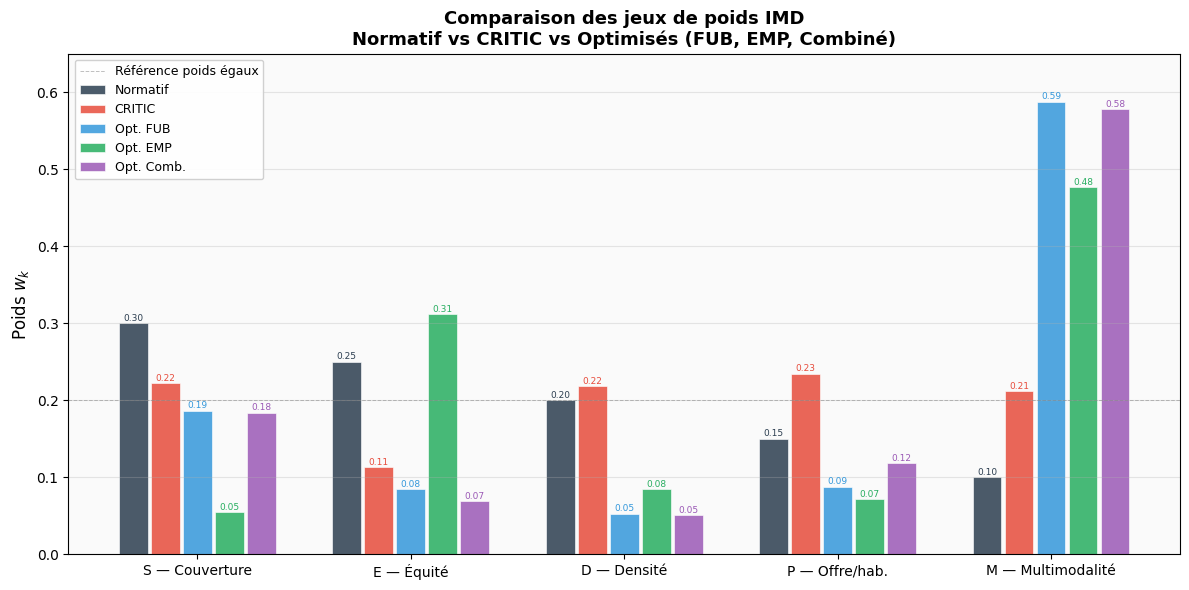

Figure A → ../../output/25_Optimisation_Poids_IMD/figures/fig_A_weights_comparison.png


In [7]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_facecolor('#fafafa')

n_methods = len(WEIGHTS_DICT)
n_comps   = 5
x = np.arange(n_comps)
width = 0.15
offsets = np.linspace(-(n_methods-1)/2, (n_methods-1)/2, n_methods) * width
col_list = list(COLORS.values())

for idx, (name, w) in enumerate(WEIGHTS_DICT.items()):
    bars = ax.bar(x + offsets[idx], w, width=width * 0.9,
                  color=col_list[idx], alpha=0.85, label=name,
                  edgecolor='white', linewidth=0.5)
    for bar, val in zip(bars, w):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.003,
                f'{val:.2f}', ha='center', fontsize=6.5, color=col_list[idx])

ax.axhline(0.2, color='gray', lw=0.7, ls='--', alpha=0.5, label='Référence poids égaux')
ax.set_xticks(x)
ax.set_xticklabels(COMP_NAMES, fontsize=10)
ax.set_ylabel('Poids $w_k$', fontsize=12)
ax.set_title("Comparaison des jeux de poids IMD\n"
             "Normatif vs CRITIC vs Optimisés (FUB, EMP, Combiné)", fontsize=13, fontweight='bold')
ax.legend(fontsize=9, framealpha=0.9)
ax.set_ylim(0, 0.65)
ax.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
fig_path = f"{FIGURES_DIR}/fig_A_weights_comparison.png"
plt.savefig(fig_path, dpi=150, bbox_inches='tight')
plt.show()
print(f"Figure A → {fig_path}")


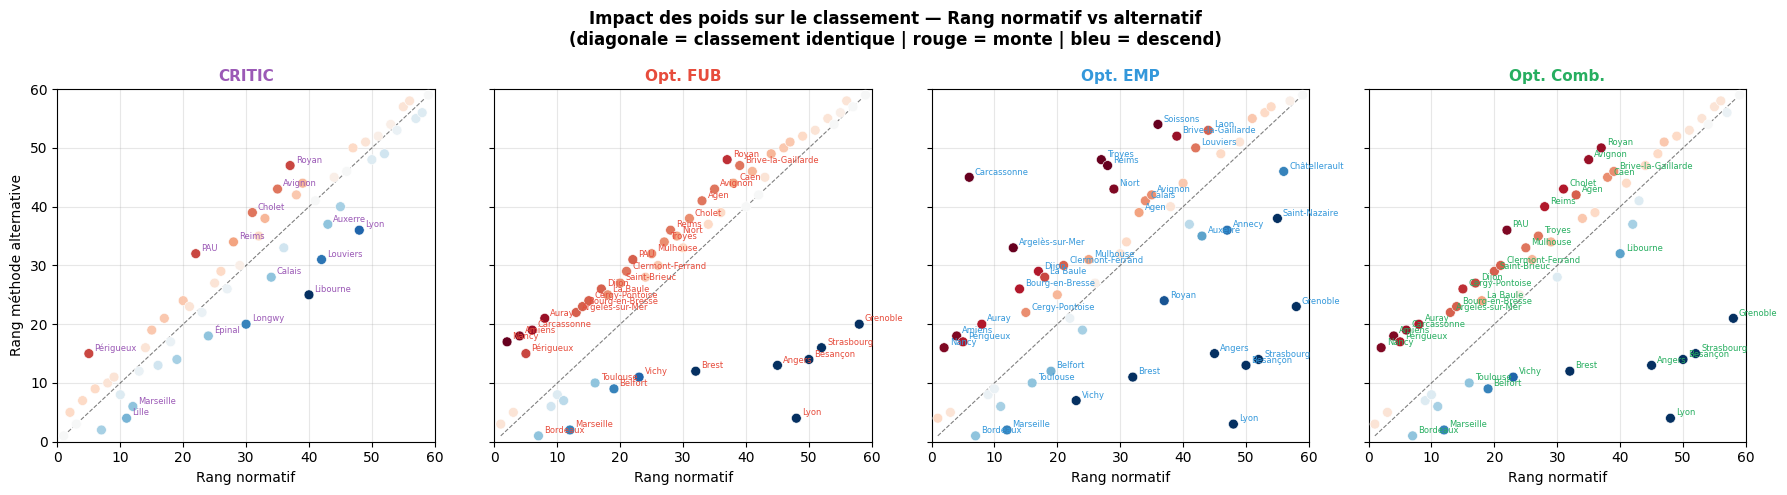

Figure B → ../../output/25_Optimisation_Poids_IMD/figures/fig_B_rank_comparison.png


In [8]:
# Compute ranks for all methods
n = len(df_full)

def imd_to_rank(w, X=X_all):
    imd = X @ w
    return n + 1 - pd.Series(imd).rank().values   # 1 = best

ranks = {name: imd_to_rank(w) for name, w in WEIGHTS_DICT.items()}
rank_norm = ranks['Normatif']

fig, axes = plt.subplots(1, 4, figsize=(18, 5), sharey=True)
methods_to_plot = ['CRITIC', 'Opt. FUB', 'Opt. EMP', 'Opt. Comb.']
cities = df_full['city'].values

for ax, method in zip(axes, methods_to_plot):
    rank_alt = ranks[method]
    delta = rank_norm - rank_alt   # positive = monte dans le classement
    color = COLORS[{'CRITIC':'critic','Opt. FUB':'fub','Opt. EMP':'emp','Opt. Comb.':'combined'}[method]]

    ax.scatter(rank_norm, rank_alt, c=delta, cmap='RdBu', s=50,
               vmin=-15, vmax=15, zorder=3, edgecolors='white', lw=0.4)
    ax.plot([1, n], [1, n], 'k--', lw=0.8, alpha=0.5)

    # Label cities with |delta| > 5
    for i, (rn, ra, city) in enumerate(zip(rank_norm, rank_alt, cities)):
        if abs(rn - ra) > 5:
            ax.annotate(city, (rn, ra), textcoords='offset points',
                        xytext=(4, 2), fontsize=6, color=color)

    ax.set_title(f'{method}', fontsize=11, fontweight='bold', color=color)
    ax.set_xlabel('Rang normatif', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, n+1); ax.set_ylim(0, n+1)

axes[0].set_ylabel('Rang méthode alternative', fontsize=10)
fig.suptitle("Impact des poids sur le classement - Rang normatif vs alternatif\n"
             "(diagonale = classement identique | rouge = monte | bleu = descend)",
             fontsize=12, fontweight='bold')
plt.tight_layout()
fig_path = f"{FIGURES_DIR}/fig_B_rank_comparison.png"
plt.savefig(fig_path, dpi=150, bbox_inches='tight')
plt.show()
print(f"Figure B → {fig_path}")


In [9]:
# ── Monte Carlo : tirage Dirichlet (uniforme sur le simplex) ─────────────
print(f"Monte Carlo : {N_MC} tirages...")
np.random.seed(42)
w_samples = dirichlet.rvs(np.ones(5), size=N_MC * 3)   # oversample then filter
w_samples = w_samples[np.all(w_samples >= W_MIN, axis=1)][:N_MC]
print(f"  Après filtre w_k >= {W_MIN} : {len(w_samples)} tirages retenus")

# Compute IMD and rank for each draw
imd_mc    = X_all @ w_samples.T          # (n_cities, N_MC)
rank_mc   = imd_mc.shape[0] + 1 - np.apply_along_axis(
                lambda x: pd.Series(x).rank().values, 0, imd_mc)   # (n_cities, N_MC)

# Top-10 frequency
top10_freq = (rank_mc <= 10).mean(axis=1)   # fraction of draws where city is top-10

# Rank statistics
rank_mean   = rank_mc.mean(axis=1)
rank_std    = rank_mc.std(axis=1)
rank_p05    = np.percentile(rank_mc, 5, axis=1)
rank_p95    = np.percentile(rank_mc, 95, axis=1)

# Spearman with normative rank - for each MC draw
r_mc_norm = np.array([
    spearmanr(rank_mc[:, i], rank_norm).statistic for i in range(len(w_samples))
])

print(f"\nCorr. de Spearman rang-MC vs rang-normatif :")
print(f"  Médiane  = {np.median(r_mc_norm):.4f}")
print(f"  P5 / P95 = {np.percentile(r_mc_norm, 5):.4f} / {np.percentile(r_mc_norm, 95):.4f}")
print(f"\nTop-10 toujours présentes (fréquence > 80%) :")
df_full['top10_freq_mc'] = top10_freq
stable = df_full[top10_freq > 0.80].sort_values('rang')[['city','rang','IMD']]
print(stable.to_string(index=False))


Monte Carlo : 10000 tirages...
  Après filtre w_k >= 0.05 : 9498 tirages retenus



Corr. de Spearman rang-MC vs rang-normatif :
  Médiane  = 0.9177
  P5 / P95 = 0.6123 / 0.9873

Top-10 toujours présentes (fréquence > 80%) :
    city  rang    IMD
  Nantes     1 0.7376
  Rennes     3 0.6608
Bordeaux     7 0.6078
   Lille    11 0.5843


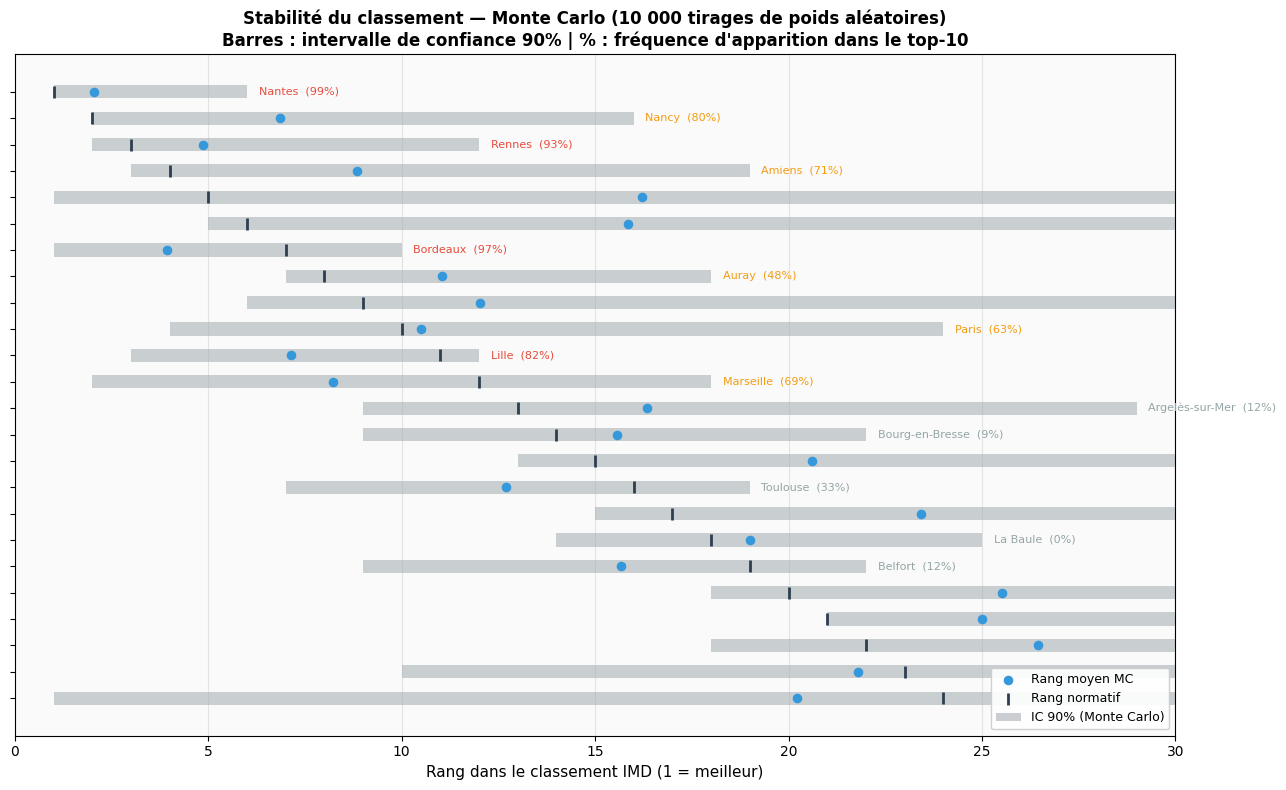

Figure C → ../../output/25_Optimisation_Poids_IMD/figures/fig_C_monte_carlo_stability.png


In [10]:
# Figure C - Distribution des rangs (top-25) + intervalles de confiance MC
top25_idx = df_full['rang'].values <= 25
cities_25 = df_full.loc[top25_idx, 'city'].values
rank_norm_25 = rank_norm[top25_idx]
rank_mean_25 = rank_mean[top25_idx]
rank_p05_25  = rank_p05[top25_idx]
rank_p95_25  = rank_p95[top25_idx]
top10f_25    = top10_freq[top25_idx]

# Sort by normative rank
order = np.argsort(rank_norm_25)

fig, ax = plt.subplots(figsize=(13, 8))
ax.set_facecolor('#fafafa')
y = np.arange(len(order))

# Error bars (P5-P95)
ax.barh(y, rank_p95_25[order] - rank_p05_25[order],
        left=rank_p05_25[order], height=0.5,
        color='#bdc3c7', alpha=0.8, label='IC 90% (Monte Carlo)')

# Mean rank
ax.scatter(rank_mean_25[order], y, color='#3498db', s=35, zorder=4, label='Rang moyen MC')

# Normative rank
ax.scatter(rank_norm_25[order], y, color='#2c3e50', marker='|', s=80,
           zorder=5, linewidths=2, label='Rang normatif')

# Color by top-10 frequency
for i, (yi, freq) in enumerate(zip(y, top10f_25[order])):
    alpha_label = 0.4 + 0.6 * freq
    color = '#e74c3c' if freq > 0.8 else '#f39c12' if freq > 0.4 else '#95a5a6'
    ax.annotate(f'{cities_25[order][i]}  ({freq:.0%})', (rank_p95_25[order][i] + 0.3, yi),
                va='center', fontsize=8, color=color)

ax.set_yticks(y)
ax.set_yticklabels([])
ax.set_xlabel('Rang dans le classement IMD (1 = meilleur)', fontsize=11)
ax.set_title("Stabilité du classement - Monte Carlo (10 000 tirages de poids aléatoires)\n"
             "Barres : intervalle de confiance 90% | % : fréquence d'apparition dans le top-10",
             fontsize=12, fontweight='bold')
ax.legend(loc='lower right', fontsize=9, framealpha=0.9)
ax.set_xlim(0, 30); ax.invert_yaxis()
ax.grid(True, axis='x', alpha=0.3)
plt.tight_layout()
fig_path = f"{FIGURES_DIR}/fig_C_monte_carlo_stability.png"
plt.savefig(fig_path, dpi=150, bbox_inches='tight')
plt.show()
print(f"Figure C → {fig_path}")


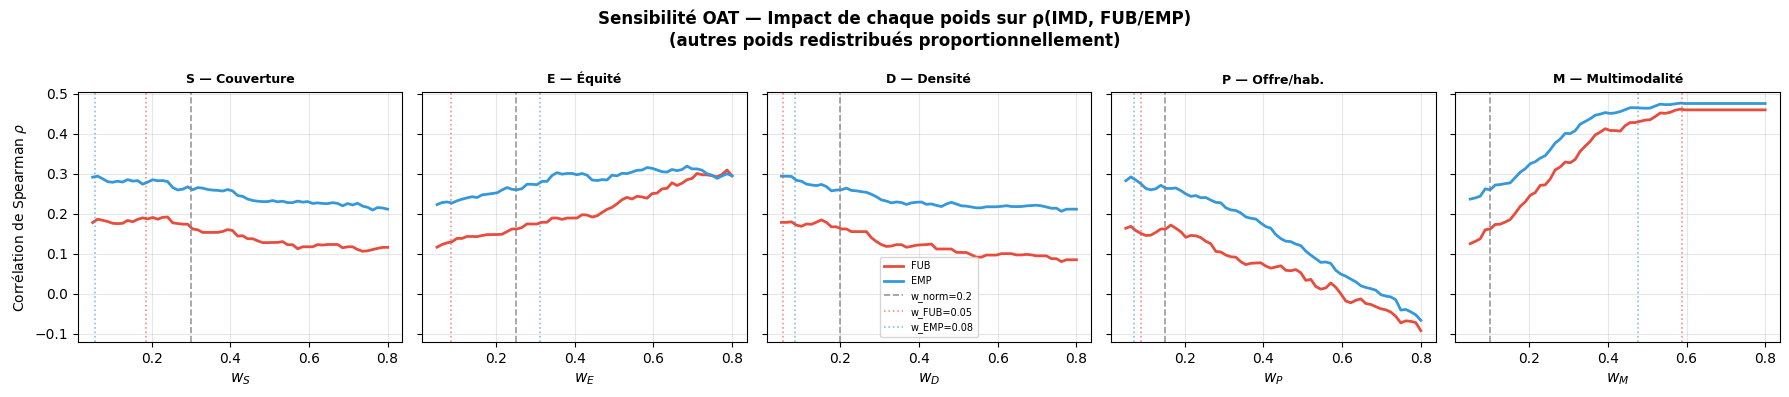

Figure D → ../../output/25_Optimisation_Poids_IMD/figures/fig_D_sensitivity_OAT.png


In [11]:
# Figure D - Sensibilité OAT : ρ(IMD, FUB) en fonction de w_k
fig, axes = plt.subplots(1, 5, figsize=(18, 4), sharey=True)
w_range = np.linspace(W_MIN, 1 - 4*W_MIN, 60)

for ax, k, name in zip(axes, range(5), COMP_NAMES):
    rho_fub_k, rho_emp_k = [], []
    for wk in w_range:
        # Redistribute remaining weight proportionally on other components
        remaining = 1 - wk
        w_others  = W_NORM.copy(); w_others[k] = 0
        if w_others.sum() > 0:
            w_others = w_others / w_others.sum() * remaining
        else:
            w_others = np.full(5, remaining / 4)
        w_test     = w_others.copy(); w_test[k] = wk
        imd_test   = X_all @ w_test
        rho_fub_k.append(spearmanr(imd_test[mask_fub], y_fub).statistic)
        rho_emp_k.append(spearmanr(imd_test[mask_emp], y_emp).statistic)

    ax.plot(w_range, rho_fub_k, color=COLORS['fub'], lw=2, label='FUB')
    ax.plot(w_range, rho_emp_k, color=COLORS['emp'], lw=2, label='EMP')
    ax.axvline(W_NORM[k], color='gray', lw=1.2, ls='--', alpha=0.8, label=f'w_norm={W_NORM[k]}')
    ax.axvline(W_FUB[k],  color=COLORS['fub'], lw=1.2, ls=':', alpha=0.6, label=f'w_FUB={W_FUB[k]:.2f}')
    ax.axvline(W_EMP[k],  color=COLORS['emp'], lw=1.2, ls=':', alpha=0.6, label=f'w_EMP={W_EMP[k]:.2f}')
    ax.set_xlabel(f'$w_{{{COMPS[k][-1]}}}$', fontsize=11)
    ax.set_title(name, fontsize=9, fontweight='bold')
    ax.grid(True, alpha=0.3)
    if k == 0:
        ax.set_ylabel('Corrélation de Spearman $\\rho$', fontsize=10)
    if k == 2:
        ax.legend(fontsize=7, loc='lower center')

fig.suptitle("Sensibilité OAT - Impact de chaque poids sur ρ(IMD, FUB/EMP)\n"
             "(autres poids redistribués proportionnellement)",
             fontsize=12, fontweight='bold')
plt.tight_layout()
fig_path = f"{FIGURES_DIR}/fig_D_sensitivity_OAT.png"
plt.savefig(fig_path, dpi=150, bbox_inches='tight')
plt.show()
print(f"Figure D → {fig_path}")


In [12]:
# Export 1 - Tableau des poids
df_weights = pd.DataFrame(WEIGHTS_DICT, index=COMPS).T.round(4)
df_weights.index.name = 'methode'
corr_rows = []
for name, w in WEIGHTS_DICT.items():
    imd_w = X_all @ w
    rf = spearmanr(imd_w[mask_fub], y_fub).statistic
    re = spearmanr(imd_w[mask_emp], y_emp).statistic
    corr_rows.append({'methode': name, 'rho_FUB': round(rf,4), 'rho_EMP': round(re,4)})
df_corr = pd.DataFrame(corr_rows).set_index('methode')
df_weights_full = df_weights.join(df_corr)
df_weights_full.to_csv(f"{TABLES_DIR}/weights_comparison.csv", encoding='utf-8')
print("weights_comparison.csv ✓")

# Export 2 - Rangs par méthode
df_ranks = df_full[['rang','city','IMD']].copy()
for name, w in WEIGHTS_DICT.items():
    imd_w = X_all @ w
    df_ranks[f'rang_{name.lower().replace(". ","_").replace(".","").replace(" ","")}'] = (
        len(df_full) + 1 - pd.Series(imd_w).rank().astype(int).values
    )
df_ranks.to_csv(f"{TABLES_DIR}/ranks_by_method.csv", index=False, encoding='utf-8')
print("ranks_by_method.csv ✓")

# Export 3 - Monte Carlo summary
df_mc = df_full[['rang','city','IMD']].copy()
df_mc['rank_mc_mean']   = rank_mean.round(2)
df_mc['rank_mc_std']    = rank_std.round(2)
df_mc['rank_mc_p05']    = rank_p05.astype(int)
df_mc['rank_mc_p95']    = rank_p95.astype(int)
df_mc['top10_freq_mc']  = top10_freq.round(4)
df_mc.to_csv(f"{TABLES_DIR}/monte_carlo_summary.csv", index=False, encoding='utf-8')
print("monte_carlo_summary.csv ✓")

print("\n=== RÉSUMÉ FINAL ===")
print(df_weights_full.to_string())


weights_comparison.csv ✓
ranks_by_method.csv ✓
monte_carlo_summary.csv ✓

=== RÉSUMÉ FINAL ===
              C1_S    C2_E    C3_D    C4_P    C5_M  rho_FUB  rho_EMP
methode                                                             
Normatif    0.3000  0.2500  0.2000  0.1500  0.1000   0.1622   0.2602
CRITIC      0.2220  0.1133  0.2185  0.2346  0.2117   0.2081   0.2772
Opt. FUB    0.1867  0.0849  0.0529  0.0877  0.5879   0.4720   0.4810
Opt. EMP    0.0548  0.3121  0.0844  0.0717  0.4770   0.5191   0.5571
Opt. Comb.  0.1839  0.0689  0.0511  0.1184  0.5776   0.4728   0.4748


## Conclusions

### Méthode CRITIC (non-supervisée)
Pondère les composantes par leur contenu informationnel (variance × divergence avec les autres).
Peut différer significativement des poids normatifs si certaines composantes sont très corrélées entre elles.

### Optimisation supervisée
Maximise la corrélation de Spearman avec la note FUB (perception citoyenne) et la part
modale EMP (comportement réel). Si les corrélations optimisées dépassent nettement les corrélations
normatives → les poids normatifs sous-exploitent l'information disponible.

Un gain faible (< 0.05 en ρ) suggère que le classement est **robuste** au choix des poids.
Un gain fort (> 0.10 en ρ) justifie de reconsidérer les poids.

### Monte Carlo (sensibilité)
- Un **IC 90% étroit** pour une ville = son rang est stable quels que soient les poids → confiance élevée
- Un **IC 90% large** = son rang dépend fortement des hypothèses → résultat fragile
- Les villes avec **fréquence top-10 > 80%** sont des leaders robustes

### Recommandation
Si les poids optimisés améliorent significativement ρ sans déstabiliser le classement
(corrélation de Spearman rang-normatif vs rang-optimisé > 0.95), ils peuvent être adoptés
avec une justification empirique. Sinon, les poids normatifs restent défendables sous
réserve d'une analyse de sensibilité documentée.

## Références
- Diakoulaki, D. et al. (1995). Determining objective weights in multiple criteria problems.
  *Computers & Operations Research*, 22(7), 763–770.
- Saltelli, A. et al. (2008). *Global Sensitivity Analysis: The Primer*. Wiley.
- OECD/JRC (2008). *Handbook on Constructing Composite Indicators*. OECD Publishing.
